Saving data.csv to data.csv
Original number of rows: 4600
Original columns: ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

Number of rows after cleaning: 3757
              price  sqft_living     bedrooms    bathrooms
count  3.757000e+03  3757.000000  3757.000000  3757.000000
mean   4.731519e+05  1926.822199     3.316210     2.049241
min    7.800000e+03   370.000000     1.000000     0.750000
25%    3.100000e+05  1390.000000     3.000000     1.500000
50%    4.370000e+05  1850.000000     3.000000     2.000000
75%    5.973260e+05  2380.000000     4.000000     2.500000
max    1.150000e+06  4130.000000     9.000000     5.750000
std    2.074133e+05   706.241941     0.869606     0.690970

Training set: 2629 records, Test set: 1128 records
Cross-validation R²: 0.542 (+/- 0.046)

=== Model Evaluation ===
RMSE: $138,191.03
MAE : 

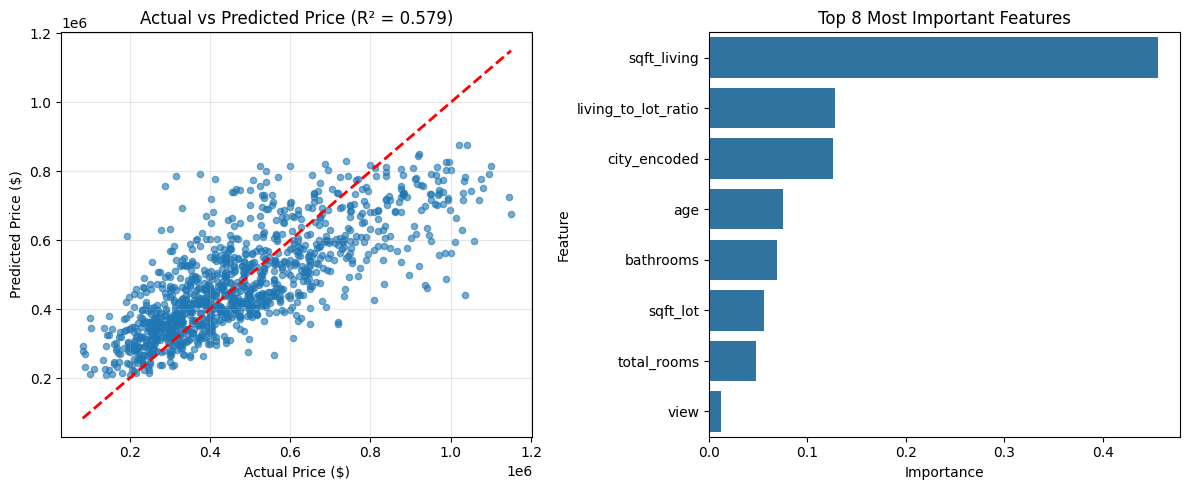


Mean Absolute Error: $106,776.96
Median Absolute Error: $86,186.04

Error Analysis by Price Range:
                      Absolute_Error            Actual
                                mean     median  count
price                                                 
(81933.0, 296400.0]        104397.13   91525.97    227
(296400.0, 509800.0]        78355.48   58088.16    480
(509800.0, 723200.0]       103070.78   94685.05    259
(723200.0, 936600.0]       157987.02  148532.73    112
(936600.0, 1150000.0]      294915.05  275718.31     50


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import warnings
warnings.filterwarnings('ignore')


# Upload CSV file
uploaded = files.upload()
path = list(uploaded.keys())[0]
df = pd.read_csv(path, encoding_errors="ignore")

print(f"Original number of rows: {len(df)}")
print("Original columns:", df.columns.tolist())


# Drop rows with missing key values
df = df.dropna(subset=['price', 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'date'])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Extract year and month, extract zip code
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['zip'] = df['statezip'].astype(str).str.split().str[-1]

# Filter unrealistic values
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] > 0]
df = df[(df['sqft_living'] > 100) & (df['sqft_lot'] > 100)]
df = df[(df['floors'] > 0) & (df['floors'] <= 4)]
df = df[df['yr_built'] >= 1900]
df = df[df['price'] > 0]


# Function to remove outliers using IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'sqft_lot')

print("\nNumber of rows after cleaning:", len(df))
print(df.describe()[['price', 'sqft_living', 'bedrooms', 'bathrooms']])


# Feature engineering
df['age'] = 2014 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['living_to_lot_ratio'] = df['sqft_living'] / df['sqft_lot']

le_city = LabelEncoder()
df['city_encoded'] = le_city.fit_transform(df['city'])

core_features = [
    'sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition',
    'age', 'is_renovated', 'total_rooms', 'living_to_lot_ratio', 'city_encoded'
]

X = df[core_features]
y = df['price']


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\nTraining set: {len(X_train)} records, Test set: {len(X_test)} records")


# Build Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R²: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


# Predictions
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== Model Evaluation ===")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE : ${mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")


# Plot Actual vs Predicted and Feature Importance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted Price (R² = {r2:.3f})')
plt.grid(alpha=0.3)


importance_df = pd.DataFrame({
    'Feature': core_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(8))
plt.title('Top 8 Most Important Features')
plt.tight_layout()
plt.show()


# Error analysis
abs_errors = np.abs(y_test - y_pred)
print(f"\nMean Absolute Error: ${abs_errors.mean():,.2f}")
print(f"Median Absolute Error: ${np.median(abs_errors):,.2f}")

price_bins = pd.cut(y_test, bins=5)
error_by_price = pd.DataFrame({
    'Absolute_Error': abs_errors,
    'Actual': y_test
}).groupby(price_bins).agg({'Absolute_Error': ['mean', 'median'], 'Actual': 'count'}).round(2)

print("\nError Analysis by Price Range:")
print(error_by_price)